# Implementing class for K-Means Clustering


Variation Ratio:  [0.62275064 0.06916105]


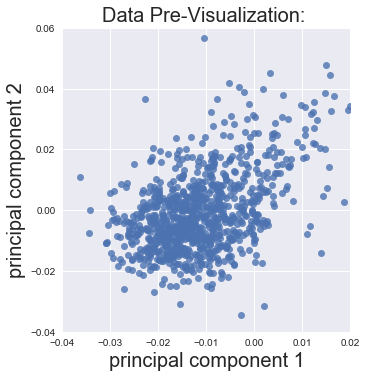

In [1]:
# K- Means
import numpy as np
import pandas as pd
from scipy import spatial
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

class K_Means:
    
    def __init__(self, filepath, ndims):
        self.__column_names = list(range(ndims))
        # DataFrame containing features with index name 'Index'
        self.__df = pd.read_csv('docs_vector.csv', names = ['Index'] + self.__column_names, index_col = 0, header=None)
        # No of dims in input
        self.__ndim = ndims
        
        # Find Principal Components for visualization
        self.__pca()
        
        # Random Samples for visualization
        self.__random_samples = np.random.choice(self.__df.shape[0], 1000, replace=False)
        
        # Visualization Parameter Set
        sns.set(rc={'figure.figsize':(10,10)})
        
    def __pca(self):
        # PCA Decomposition for Visualization
        pca = PCA(n_components=2)
        principalComponents = pca.fit_transform(self.__df)
        print('Variation Ratio: ', pca.explained_variance_ratio_)
        self.__principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
    
    def pre_visualize(self):
        df_sample = self.__principalDf.iloc[self.__random_samples,]
        lm = sns.lmplot(data=df_sample, x='principal component 1', y='principal component 2', 
                   fit_reg=False, legend=False, legend_out=True)
        plt.xlabel('principal component 1', fontsize = 20)
        plt.ylabel('principal component 2', fontsize = 20)
        plt.title('Data Pre-Visualization: ', fontsize = 20)
        plt.xlim((-0.04, 0.02))
        plt.ylim((-0.04, 0.06))
        
    def __init_centers(self):
        np.random.seed(0)
        # Initialize random data points as initial centers
        self.__centers = self.__df.reset_index().drop(['Index'], axis = 1).sample(n = self.__K)
        self.__centers.columns = self.__column_names
        self.__centers.index = pd.RangeIndex(len(self.__centers.index))
        
    def get_centers(self):
        return self.__centers
    
    def get_labels(self):
        return self.__df2['label']
    
    def __update_label(self):
        # Update Labels based on cosine similarity
        ary = spatial.distance.cdist(self.__df.iloc[:,0:], self.__centers.iloc[:,0:], metric='cosine')
        ary = pd.DataFrame(ary)

        label = ary.idxmin(axis = 1)
        self.__label = label
        self.__df2 = self.__df.copy().reset_index()
        self.__df2['label'] = label
        self.__df2 = self.__df2.set_index('Index')
        
    def __update_center(self):
        # Update Centers based on label group
        df_group_by_label = self.__df2.groupby('label').mean()
        df_group_by_label.columns = self.__column_names
        self.__old_centers = self.__centers.copy(deep = True)
        self.__centers.update(df_group_by_label)
        
    def __calc_SSE(self):
        # Calculate Sum of Squared Errors: SSE
        self.__SSE = 0
        clusters_df = self.__df2.groupby('label')
        for label_, df_ in clusters_df:
            df_ = df_.drop(['label'], axis = 1)
            center_ = self.__centers.iloc[label_,0:].to_frame().T
            ary_ = spatial.distance.cdist(df_.iloc[:,0:], center_, metric='euclidean')
            self.__SSE += ary_.sum()

    def run(self, K):
        # No of Clusters to be made
        self.__K = K
        print('K-Means Clustering Run for K = ', self.__K)
        self.__init_centers()
        
        for i in range(100):
            # Update Label
            self.__update_label()

            # Center Update
            self.__update_center()

            error = self.__old_centers.subtract(self.__centers)**2
            print('Error in Iteration', i, ': ', error.values.sum())
            if(error.values.sum() < 10**(-6)):
                print("K-Means Iteration = ", i+1)
                break
                
        self.__calc_SSE()
        
    def get_SSE(self):
        return self.__SSE
        
    def label_histogram(self):
        # Visualize Distribution of document count
        label_series = self.__df2['label'].value_counts().sort_index()
        ax = sns.barplot(label_series.index, label_series.values)
        ax.set_xlabel('Cluster #', fontsize = 20)
        ax.set_ylabel('# Documents', fontsize = 20)
        ax.set_title('K-Means Clustering with K = ' + str(self.__K), fontsize = 20)
        
    def post_visualize(self):
        # Visualize Distribution of data
        self.__principalDf['label'] = self.__label#self.get_labels()
        df2_sample = self.__principalDf.iloc[self.__random_samples,]
        lm = sns.lmplot(data=df2_sample, x='principal component 1', y='principal component 2', hue='label', 
                   fit_reg=False, legend=False, legend_out=True)
        plt.xlabel('principal component 1', fontsize = 20)
        plt.ylabel('principal component 2', fontsize = 20)
        plt.title('Data Post-Visualization: ', fontsize = 20)
        plt.xlim((-0.04, 0.02))
        plt.ylim((-0.04, 0.06))
        
    def annotated_visualize(self):
        # Visualize data with its unique identifier 'awardNo'
        samples = np.random.choice(self.__df.shape[0], 50, replace=False)
        df3_sample = self.__principalDf.iloc[samples,]
#         lm = sns.lmplot(data=df3_sample, x='principal component 1', y='principal component 2', hue='label', 
#                    fit_reg=False, legend=False, legend_out=True)
        fig = plt.figure(figsize = (8,8))
        ax = fig.add_subplot(1,1,1)
        plt.xlabel('principal component 1', fontsize = 20)
        plt.ylabel('principal component 2', fontsize = 20)
        plt.title('Data Post-Visualization: ', fontsize = 20)
        xlim_value = [-0.04, 0.02]
        ylim_value = [-0.04, 0.06] 
        plt.xlim(xlim_value)
        plt.ylim(ylim_value)
        ax.scatter(df3_sample['principal component 1']
               , df3_sample['principal component 2']
               , c = [self.__label[i] for i in df3_sample.index.values]
               , s = 50)
        #ax.legend(kmeans.labels_)
        ax.grid()

        for line in range(0,df3_sample.shape[0]):
            x_val = df3_sample['principal component 1'].values[line]
            y_val = df3_sample['principal component 2'].values[line]
            #annt_text = str(df3_sample.index.values[line])
            annt_text = str(self.__df2.index.values[line])
            if(x_val < xlim_value[0] or x_val > xlim_value[1]):
                continue
            if(y_val < ylim_value[0] or y_val > ylim_value[1]):
                continue
            #lm.ax.fig.text(x_val, y_val, annt_text)
            #lm.ax.text(annt_text, xy = (x_val, y_val))
            ax.annotate(annt_text, xy = (x_val, y_val))
        
    
# K_Means(Input DataFrame, Input Dimension)
obj = K_Means('docs_vector.csv', 300)
obj.pre_visualize()

In [2]:
SSE_dict = {}

K-Means Clustering Run for K =  5
Error in Iteration 0 :  0.0032826095770901002
Error in Iteration 1 :  0.006771583743163979
Error in Iteration 2 :  0.01245028267285354
Error in Iteration 3 :  6.036561490017781e-05
Error in Iteration 4 :  1.4341205455979517e-05
Error in Iteration 5 :  6.734704702323499e-06
Error in Iteration 6 :  6.40895395931624e-06
Error in Iteration 7 :  5.7961152596977695e-06
Error in Iteration 8 :  4.333306185068588e-06
Error in Iteration 9 :  3.3906860011436953e-06
Error in Iteration 10 :  1.7540417428769392e-06
Error in Iteration 11 :  8.92881978963144e-07
K-Means Iteration =  12
SSE =  1542.92066089145


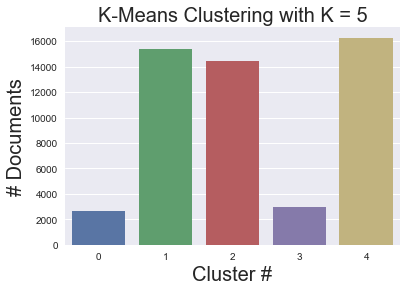

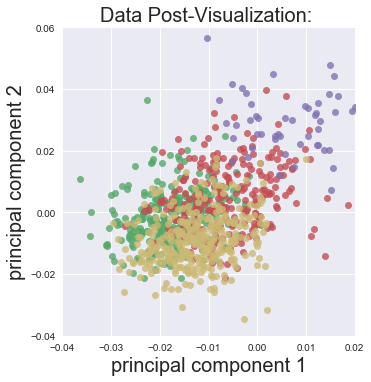

In [3]:
K = 5
obj.run(K)
obj.label_histogram()
obj.post_visualize()
#obj.get_labels().head()
sse = obj.get_SSE()
print('SSE = ', sse)
SSE_dict[K] = sse

# Annotate Docs

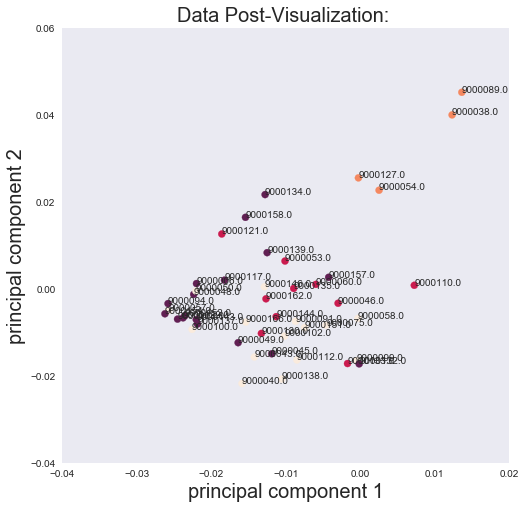

In [4]:
obj.annotated_visualize()

K-Means Clustering Run for K =  7
Error in Iteration 0 :  0.00771924670141317
Error in Iteration 1 :  0.022856191077638845
Error in Iteration 2 :  0.00028987912543283816
Error in Iteration 3 :  3.912726969667144e-05
Error in Iteration 4 :  1.4721494687561033e-05
Error in Iteration 5 :  8.294894126556058e-06
Error in Iteration 6 :  6.2368226740115764e-06
Error in Iteration 7 :  5.877371644989304e-06
Error in Iteration 8 :  5.320221139381692e-06
Error in Iteration 9 :  5.236114926435346e-06
Error in Iteration 10 :  6.646285280867007e-06
Error in Iteration 11 :  8.222652517979001e-06
Error in Iteration 12 :  1.1282070574047213e-05
Error in Iteration 13 :  1.6755295915248588e-05
Error in Iteration 14 :  2.886443559979363e-05
Error in Iteration 15 :  3.7602405995510984e-05
Error in Iteration 16 :  5.061416332640317e-05
Error in Iteration 17 :  8.495299688291653e-05
Error in Iteration 18 :  9.860914817408298e-05
Error in Iteration 19 :  0.00013195378918221608
Error in Iteration 20 :  0.00013

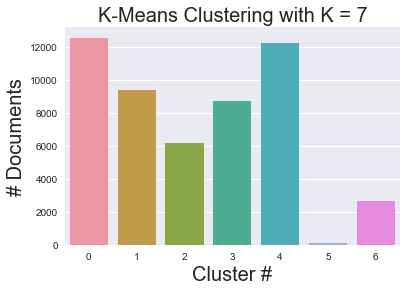

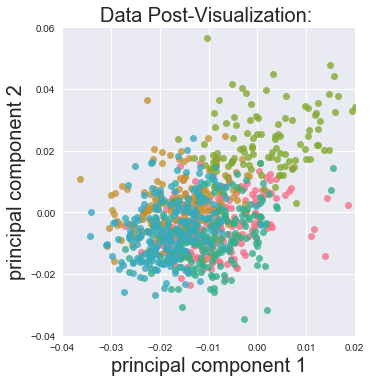

In [5]:
K = 7
obj.run(K)
obj.label_histogram()
obj.post_visualize()
#obj.get_labels().head()
sse = obj.get_SSE()
print('SSE = ', sse)
SSE_dict[K] = sse

K-Means Clustering Run for K =  10
Error in Iteration 0 :  0.011244089126266697
Error in Iteration 1 :  0.02280384002182271
Error in Iteration 2 :  0.0010488442640448513
Error in Iteration 3 :  0.0005427481412857979
Error in Iteration 4 :  0.0005378013266556542
Error in Iteration 5 :  0.00031356476407102076
Error in Iteration 6 :  9.335315908960472e-05
Error in Iteration 7 :  1.8657629355698288e-05
Error in Iteration 8 :  1.5733745888435204e-05
Error in Iteration 9 :  9.13462384584676e-06
Error in Iteration 10 :  7.430664503993653e-06
Error in Iteration 11 :  5.521086333586963e-06
Error in Iteration 12 :  9.443610076473044e-07
K-Means Iteration =  13
SSE =  1464.0812941571257


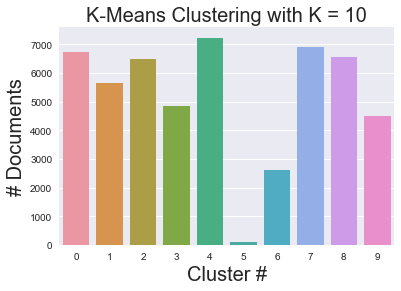

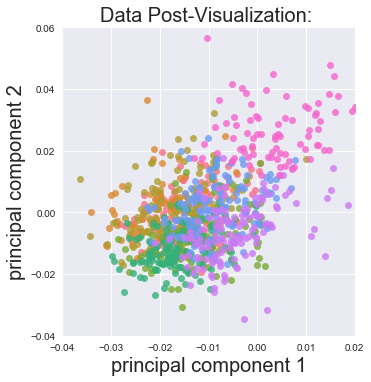

In [6]:
K = 10
obj.run(K)
obj.label_histogram()
obj.post_visualize()
#obj.get_labels().head()
sse = obj.get_SSE()
print('SSE = ', sse)
SSE_dict[K] = sse

K-Means Clustering Run for K =  12
Error in Iteration 0 :  0.012503718895253016
Error in Iteration 1 :  0.021610839833416627
Error in Iteration 2 :  0.0005875842908548104
Error in Iteration 3 :  0.0003435750013363409
Error in Iteration 4 :  0.0002065917043811728
Error in Iteration 5 :  0.00010121472374116793
Error in Iteration 6 :  0.00011425148781248767
Error in Iteration 7 :  1.737920778132355e-05
Error in Iteration 8 :  6.136556569932691e-06
Error in Iteration 9 :  5.598188840621283e-06
Error in Iteration 10 :  4.6118142546894466e-06
Error in Iteration 11 :  3.9952287608198335e-06
Error in Iteration 12 :  4.127407950935107e-06
Error in Iteration 13 :  3.6121159200273073e-06
Error in Iteration 14 :  3.29652902501945e-06
Error in Iteration 15 :  3.5515250407313833e-06
Error in Iteration 16 :  2.4785669663460702e-06
Error in Iteration 17 :  2.008539179176176e-06
Error in Iteration 18 :  2.568682144680779e-06
Error in Iteration 19 :  1.8298745397274892e-06
Error in Iteration 20 :  1.561

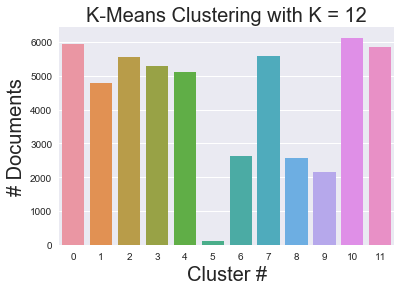

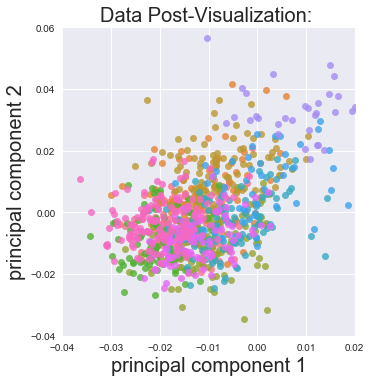

In [7]:
K = 12
obj.run(K)
obj.label_histogram()
obj.post_visualize()
#obj.get_labels().head()
sse = obj.get_SSE()
print('SSE = ', sse)
SSE_dict[K] = sse

K-Means Clustering Run for K =  15
Error in Iteration 0 :  0.013946293715564672
Error in Iteration 1 :  0.021021610107502482
Error in Iteration 2 :  0.0006990646605711247
Error in Iteration 3 :  0.0003242981375825116
Error in Iteration 4 :  0.00021498659151400457
Error in Iteration 5 :  9.156872403078338e-05
Error in Iteration 6 :  0.0001498643064761121
Error in Iteration 7 :  2.1683755898752346e-05
Error in Iteration 8 :  1.0819166692757522e-05
Error in Iteration 9 :  7.867384477563145e-06
Error in Iteration 10 :  1.1506266224959873e-05
Error in Iteration 11 :  3.7314175820572658e-06
Error in Iteration 12 :  3.252522656683269e-06
Error in Iteration 13 :  3.836764588909229e-06
Error in Iteration 14 :  2.503588520297533e-06
Error in Iteration 15 :  4.041466680967028e-06
Error in Iteration 16 :  1.3338804089560458e-06
Error in Iteration 17 :  1.2953526198134444e-06
Error in Iteration 18 :  1.472445612237809e-06
Error in Iteration 19 :  1.3036587523399975e-06
Error in Iteration 20 :  1.30

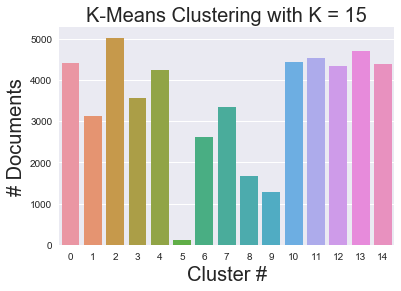

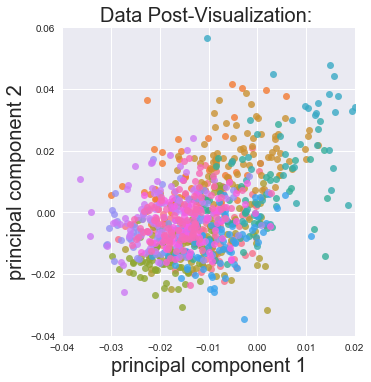

In [8]:
K = 15
obj.run(K)
obj.label_histogram()
obj.post_visualize()
#obj.get_labels().head()
sse = obj.get_SSE()
print('SSE = ', sse)
SSE_dict[K] = sse

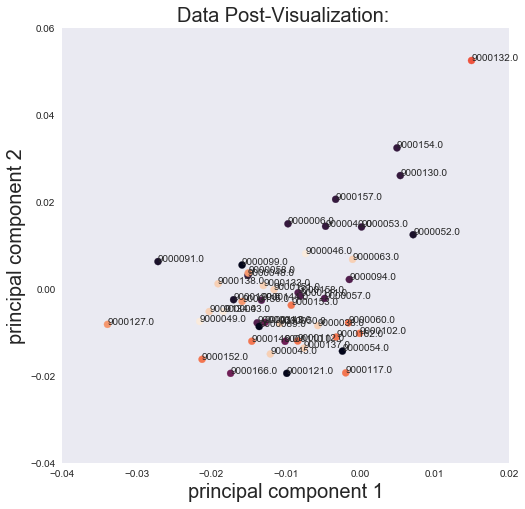

In [16]:
obj.annotated_visualize()

# K-Means SSE Profile

In [10]:
print(SSE_dict)
print(SSE_dict.keys())
print(SSE_dict.values())


{5: 1542.92066089145, 7: 1500.4978755829402, 10: 1464.0812941571257, 12: 1437.6473829112847, 15: 1416.7835914068576}
dict_keys([5, 7, 10, 12, 15])
dict_values([1542.92066089145, 1500.4978755829402, 1464.0812941571257, 1437.6473829112847, 1416.7835914068576])


Text(0.5,1,'SSE Profile')

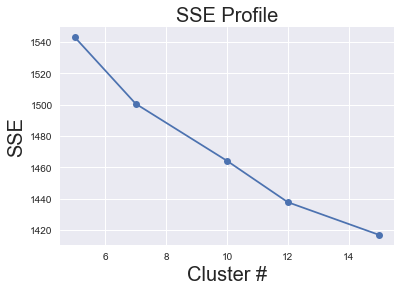

In [11]:
plt.plot(SSE_dict.keys(), SSE_dict.values(), 'o-')
plt.xlabel('Cluster #', fontsize = 20)
plt.ylabel('SSE', fontsize = 20)
plt.title('SSE Profile', fontsize = 20)